In [1]:
#from spatial_metabolic_distribution import Maps, MetabolicPropertyMapsAssembler
from spectral_spatial_simulation import Model as SpectralSpatialModel
from spectral_spatial_simulation import FID
from sampling import Model as SamplingModel
from matplotlib.pyplot import legend, title
import matplotlib.pyplot as plt
from display import plot_FID
from easygraph import Graph
#from printer import Console
from prettyconsole import Console
import dask.array as da
import numpy as np
import cupy as cp
import os.path
import tools
import dask
import pint
import file
import h5py
import sys

from tqdm import tqdm
import warnings

# Both required for the JupyterPlotManager
from tools import JupyterPlotManager
%matplotlib ipympl

# For e.g., storing to disk (dask.to_zarr)
from tools import DaskTools

# For some incomplete data
from spatial_metabolic_distribution import ParameterMap, ParameterVolume

In [2]:
# Initialise the UnitRegistry
u = pint.UnitRegistry()

# Initialise the graph (visual representation)

In [3]:
g = Graph(measure_time=True)
g.add_cluster(name="Initial configuration")
g.add_cluster(name="Load and prepare the data")
g.add_cluster(name="Interpolation", supercluster="Load and prepare the data")
g.add_cluster(name="Create models")
g.add_cluster(name="GPU cluster")
g.add_cluster(name="k-space")

g.add_cluster(name="Forward Process")

# Check number of reserved CPUs and total available CPUs

In [4]:
print("available number of CPUs for this simulation (vary if reserved):")
!nproc

available number of CPUs for this simulation (vary if reserved):
40


In [5]:
print("all logical CPUs on the system:")
!nproc --all

all logical CPUs on the system:
40


# Check current GPU load & Define GPU(s) for small and big tasks

In [6]:
# Set generally visible GPU devices

!nvidia-smi

Sun Jan 25 15:12:39 2026       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.274.02             Driver Version: 535.274.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-DGXS-32GB           On  | 00000000:07:00.0 Off |                    0 |
| N/A   31C    P0              37W / 300W |     53MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3"

#target_gpu_smaller_tasks = 2
#target_gpus_big_tasks = [3]

target_gpu_smaller_tasks = 0
target_gpus_big_tasks = [0,1,2,3]

device_memory_limit = "32GB"

In [8]:
g.add_node(name="Target GPUs",
           text=f"Define GPU {target_gpus_big_tasks} for big tasks (limit={device_memory_limit}) and "
                f"GPU {target_gpu_smaller_tasks} for small tasks", 
           width=0.5, cluster="Initial configuration")

# Check free RAM

In [9]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:           251Gi        14Gi        26Gi        18Mi       210Gi       234Gi
Swap:             0B          0B          0B


# <span style="color:red">Define Simulation paramaters (TODO collect all important ones). Are they already base units?!</span>

In [10]:
TE=0.0013*u.s  # secound
TR=0.6*u.s     # secound
alpha=45*u.deg # degree

# Load defined paths in the configurator

In [11]:
config_file_name = "paths_09012026.json"

g.add_node(name="Config file paths", 
           text=f"Using config file for providing paths: {config_file_name}",
           cluster="Initial configuration")

In [12]:
configurator = file.Configurator(path_folder="../config/",
                                 file_name=config_file_name)
configurator.load()

# Load metabolic mask

In [13]:
g.add_node(name="Load Metabolic Mask", 
           text="Load Metabolic Mask", 
           connect_from="Config file paths", cluster="Load and prepare the data")

metabolic_mask = file.Mask(configurator=configurator)
metabolic_mask.load(mask_name="metabolites", data_type=np.float32)

[  1  ][ success ] ---v                       
                      Loaded file 'Vol_004_mask_slab.nii':
                          Shape             -> (112, 128, 80)
                          Pixel dimensions: -> (1.7188, 1.7188, 1.72)
                          Values range:     -> [0.0, 1.0]
                          Data type:        -> <class 'numpy.float32'>
                          In memory cache?  -> True
[  2  ][ success ] >> Thus, loaded the 'metabolites' mask.                                                                 


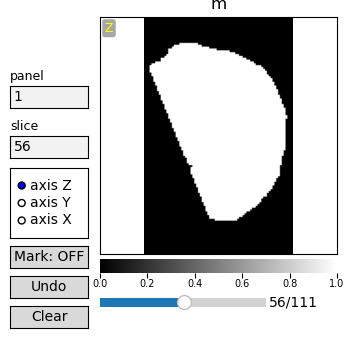

In [14]:
metabolic_mask.plot_jupyter()

# Load the FIDs

In [15]:
g.add_node(name="Load example FIDs", 
           connect_from="Config file paths", 
           cluster="Load and prepare the data")

metabolites = file.FID(configurator=configurator)
metabolites.load(fid_name="metabolites", signal_data_type=np.complex64) # TODO TODO, here seems to be an issue => data type has no effect?
metabolites.loaded_fid.change_signal_data_type("complex64")
metabolites.loaded_fid.change_time_data_type("float32")

[  3  ][  info   ] ---v                       
                      Loaded FID signal as <class 'numpy.complex64'> 
                       -> thus using space: 264.0 KB 
                       -> thus using digits: 15
[  4  ][ success ] >> Transformed FID signal to complex values: (16896, 2) -> (16896,)                                     
[  5  ][ success ] ---v  (collected several lines)                      
                      Assigned FID parts:
                      0. Acetyl+Aspartyl_moi(NAAG) -----> shape: (1536,)
                      1. Choline_moi(GPC) --------------> shape: (1536,)
                      2. Creatine (Cr) -----------------> shape: (1536,)
                      3. Glutamate (Glu) ---------------> shape: (1536,)
                      4. Glutamate_moi(NAAG) -----------> shape: (1536,)
                      5. Glutamine_noNH2 (Gln) ---------> shape: (1536,)
                      6. Glycerol_moi(GPC) -------------> shape: (1536,)
                      7. MyoIno

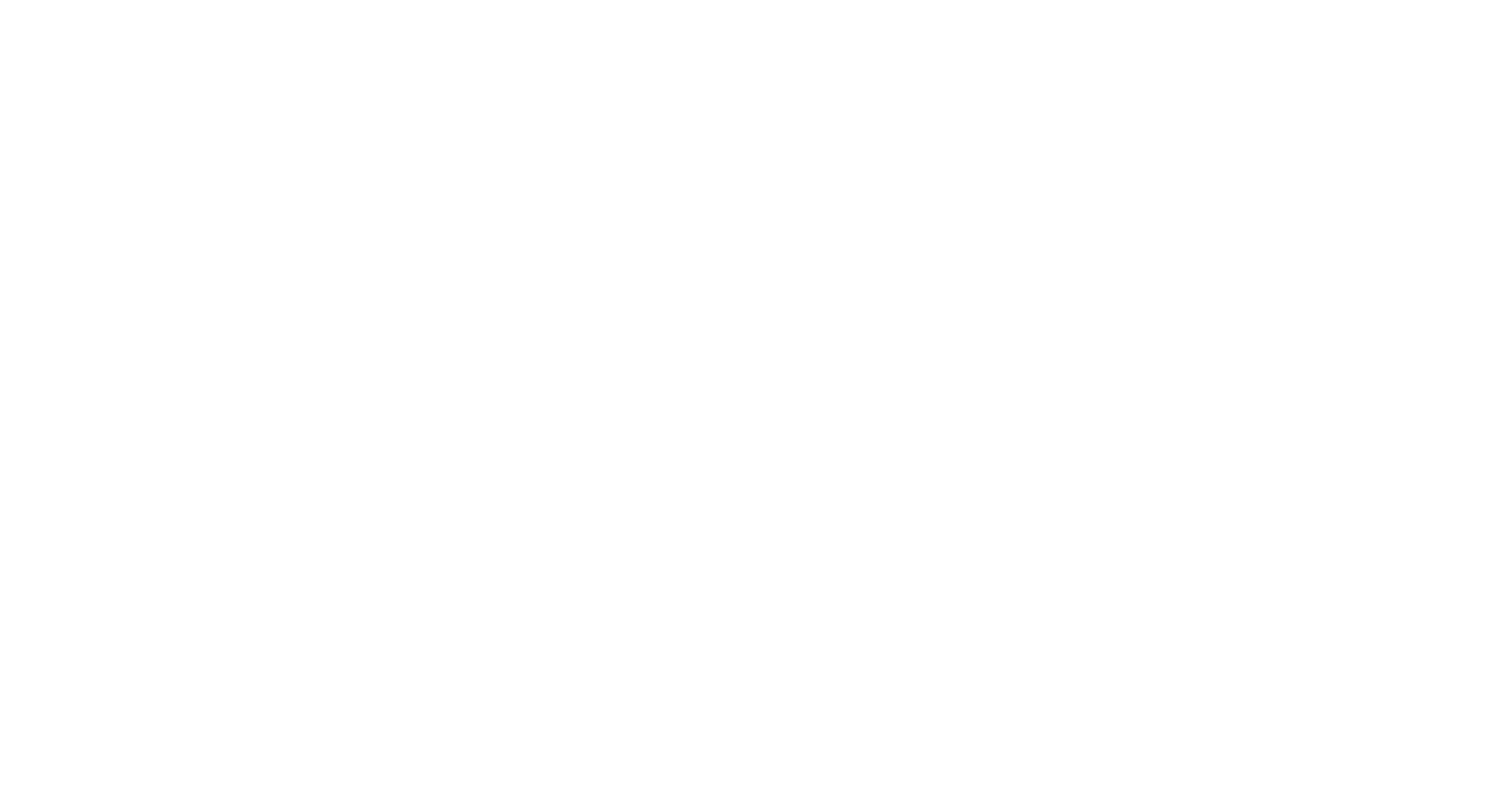

In [16]:
loaded_fid = metabolites.loaded_fid
loaded_fid.plot()

#### <span style="color:red">!!! Interpolate to 100.000 FID points for test purposes.</span>

In [17]:
loaded_fid.interpolate(timepoints=100_000)

[  9  ][ success ] ---v                       
                      Interpolated FID: 
                       => time shape:   (1536,)         --> (100000,) 
                       => signal shape: (11, 1536)      --> (11, 100000)


# Load and prepare the concentration maps

In [18]:
###text = """ =====================================================================================================
###        Step: Load and prepare concentration maps 
###        
###        Description: ´Loading the concentration maps, assigning working names and interpolating it with 2nd order. 
###                      Currently using: (a) Glu, (b) Gln, (c) m-Ins, (d) NAA, (e) Cr+PCr, (f) GPC+PCh´
###        
###                      [X] Simulated data is used
###        """
###
###g.add_node(name="Load and prepare concentration maps",
###           text=text, 
###           connect_from=["Load Metabolic Mask", "Load example FIDs"],
###           width=1.05, 
###           title_colour="green", 
###           cluster="Load and prepare the data")

#### Load the desired concentration maps

In [19]:
loaded_concentration_maps = file.ParameterMaps(configurator=configurator, map_type_name="metabolites_concentration")
working_name_and_file_name = {"Glu": "MetMap_Glu_con_map_TargetRes_HiRes.nii",
                              "Gln": "MetMap_Gln_con_map_TargetRes_HiRes.nii",
                              "m-Ins": "MetMap_Ins_con_map_TargetRes_HiRes.nii",
                              "NAA": "MetMap_NAA_con_map_TargetRes_HiRes.nii",
                              "Cr+PCr": "MetMap_Cr+PCr_con_map_TargetRes_HiRes.nii",
                              "GPC+PCh": "MetMap_GPC+PCh_con_map_TargetRes_HiRes.nii",
                             }
loaded_concentration_maps.load_files_from_folder(working_name_and_file_name=working_name_and_file_name)

[ 10  ][  info   ] >> Maps object: The provided path points to a folder                                                    
[ 11  ][ warning ] >> Maps.load_files_from_folder ==> by standard nii is loaded. No h5 support yet!                        
[ 12  ][ warning ] >> The same unit is assumed for all the files in the given folder!                                      
[ 13  ][ success ] ---v  (collected several lines)                      
                      Loaded maps: 
                        0: working name: .......Glu | Shape:   (440, 440, 266) | Values range: [0.0, 42.733] | Unit: millimole |
                        1: working name: .......Gln | Shape:   (440, 440, 266) | Values range: [0.0, 41.138] | Unit: millimole |
                        2: working name: .....m-Ins | Shape:   (440, 440, 266) | Values range: [0.0, 40.316] | Unit: millimole |
                        3: working name: .......NAA | Shape:   (440, 440, 266) | Values range: [0.0, 42.934] | Unit: millimole |
   

#### Convert to base units and display loaded data

[ 14  ][ success ] >> Converted to base units: millimole -> mole                                                           


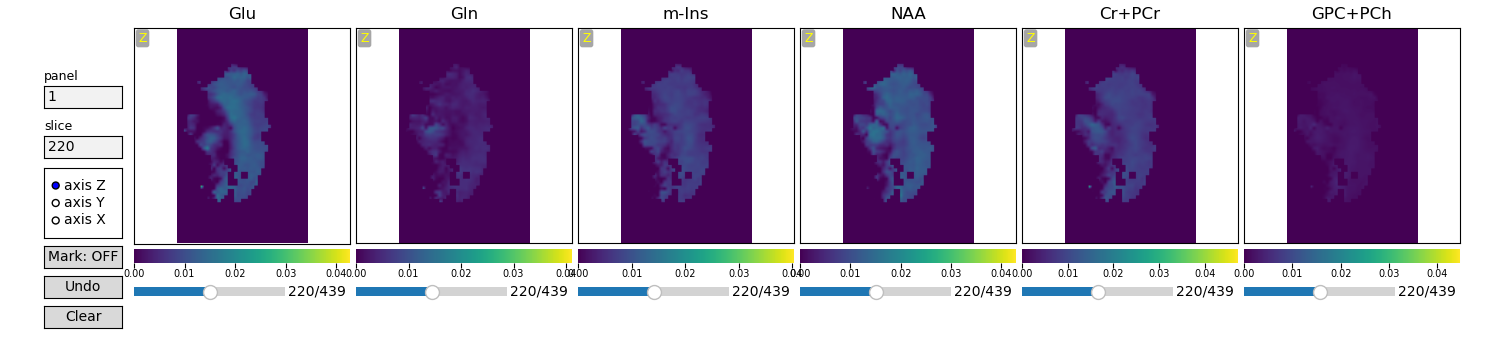

In [20]:
# Convert to base units (e.g., mmol to mol)
loaded_concentration_maps.to_base_units()
# Display the data
loaded_concentration_maps.plot_jupyter(cmap="viridis")

#### Create 4D array from the 3D arrays and interpolate to target shape

In [21]:
# Convert the file.Maps object to a ParamaterVolume of shape (metabolite, X, Y, Z) & change to float32
concentration_volume = loaded_concentration_maps.to_working_volume(data_type="float32")
# Interpolate to the shape of the 
concentration_volume.interpolate(target_size=metabolic_mask.mask.shape, order=3, device="gpu", target_gpu=target_gpu_smaller_tasks, verbose=False)

[ 15  ][ success ] ---v                       
                      Created 4D volume of metabolite maps: ['Glu', 'Gln', 'm-Ins', 'NAA', 'Cr+PCr', 'GPC+PCh']. 
                       Map type: ....... metabolites_concentration 
                       Unit: ........... mole 
                       Shape: .......... (6, 440, 440, 266) 
                       Data type: ...... float64 
                       Space: .......... 2357.4 mebibyte
[ 16  ][ success ] >> Changed the data type from float64 (2357.4 mebibyte) -> float32 (1178.7 mebibyte)                    
[ 17  ][  info   ] >> Interpolate on GPU: gpu                                                                              


# Load and prepare the T1 maps
### <span style="color:red">!!! Only one T1 map is loaded at the moment and used for each metabolite.</span>

In [22]:
text = """ =====================================================================================================
        Step: Load and prepare the T1 maps
        
        Description: Only one T1 map is loaded at the moment and used for each metabolite.
        
            [ ] Use for each metabolite a corresponding T1 map.
            [ ] Scale map not manually below to [ms]
        
        Note: The same one T1 map is for each metabolite used!
        """
g.add_node(name="Load and prepare T1 maps",
           text=text, 
           cluster="Load and prepare the data",
           title_colour="yellow")

#### <span style="color:red">!!! Load only one t1 maps and then convert to base units.</span>

In [23]:
loaded_t1_map = file.ParameterMaps(configurator=configurator, map_type_name="T1")
loaded_t1_map.load_file()
loaded_t1_map.to_base_units()

[ 18  ][  info   ] >> Maps object: The provided path points to a file                                                      
[ 19  ][  info   ] >> Loading nii file for map type T1                                                                     
[ 20  ][ success ] ---v  (collected several lines)                      
                      Loaded nii map: T1_TargetRes_HiRes.nii | Shape: (440, 440, 266) | Values range: [-327.493, 4848.004] | Unit: millisecond | Unique values: 888245
                      
[ 21  ][ success ] >> Converted to base units: millisecond -> second                                                       


#### <span style="color:red">!!! Assemble pseudo 4D array of T1 maps (same for each metabolite).</span>

In [24]:
t1_volume = ParameterVolume(maps_type="T1")

for metabolite in concentration_volume.metabolites:
    parameter_map = ParameterMap(map_type=loaded_t1_map.map_type_name, metabolite_name=metabolite, values=loaded_t1_map.loaded_maps, unit=loaded_t1_map.loaded_maps_unit)
    t1_volume.add_map(parameter_map)

t1_volume.to_volume()
t1_volume.interpolate(target_size=metabolic_mask.mask.shape, order=3, device="gpu", target_gpu=target_gpu_smaller_tasks, verbose=False)
t1_volume.to_data_type("float32")

[ 22  ][ success ] ---v                       
                      Created 4D volume of metabolite maps: ['Glu', 'Gln', 'm-Ins', 'NAA', 'Cr+PCr', 'GPC+PCh']. 
                       Map type: ....... T1 
                       Unit: ........... second 
                       Shape: .......... (6, 440, 440, 266) 
                       Data type: ...... float64 
                       Space: .......... 2357.4 mebibyte
[ 23  ][  info   ] >> Interpolate on GPU: gpu                                                                              
[ 24  ][ success ] >> Changed the data type from float64 (52.5 mebibyte) -> float32 (26.25 mebibyte)                       


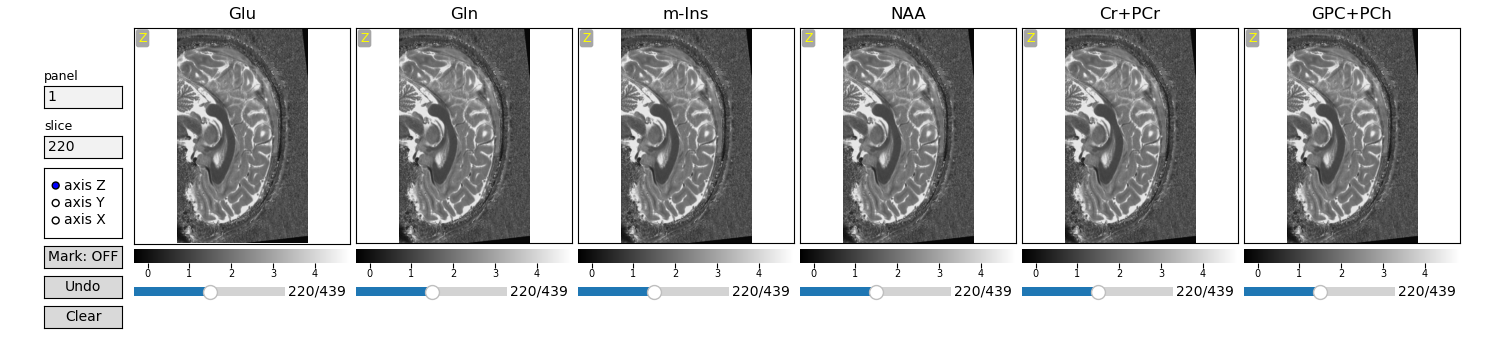

In [25]:
t1_volume.display_jupyter()

# Load and prepare the T2 maps

In [26]:
### text = """ =====================================================================================================
###         Step: Load and prepare T2 maps
###         
###         ´Description: At the moment only placeholder data is used. Therefore, mean values of certain regions in brain 
###                       from paper cited in the code.´
###             
###             [X] Using literature values at the first step: random values from distribution exhibiting mu and sigma.
###             [ ] Check if T2 and T2* correctly applied in code!
###             [X] Using T2 and T2* values from literature
###             [ ] Using a T2 and T2* map for each metabolite
###         """
### g.add_node(name="Load and prepare T2 maps", text=text, cluster="Load and prepare the data", title_colour="red")

#### <span style="color:red">!!! The reference where T2 vales ares used from. Only homogenious at the moment.</span>

In [27]:
# Using T2 values from:
cm = tools.CitationManager("../docs/references.bib")
cm.cite("versteeg2024high")
# But also see:
cm.cite("seginer2022phase")

t2_WM = (25+39)/2*u.ms
t2_GM = (33+55)/2*u.ms

t2_GM_WM_average = (t2_WM+t2_GM)/2
t2_GM_WM_average = t2_GM_WM_average.to_base_units()

t2_GM_WM_average
# Do I have GM and WM segmentation?

<Quantity(0.038, 'second')>

In [28]:
t2_volume = ParameterVolume(maps_type="T2")

for metabolite in concentration_volume.metabolites:
    parameter_map = ParameterMap(map_type="T2", metabolite_name=metabolite, values=np.full(metabolic_mask.mask.shape, t2_GM_WM_average), unit=t2_GM_WM_average.units)
    t2_volume.add_map(parameter_map)

t2_volume.to_volume()
t2_volume.to_data_type("float32")
#t2_volume.interpolate_volume(target_size=metabolic_mask.mask.shape, order=3, device="gpu", target_gpu=target_gpu_smaller_tasks, verbose=False)

[ 25  ][ success ] ---v                       
                      Created 4D volume of metabolite maps: ['Glu', 'Gln', 'm-Ins', 'NAA', 'Cr+PCr', 'GPC+PCh']. 
                       Map type: ....... T2 
                       Unit: ........... second 
                       Shape: .......... (6, 112, 128, 80) 
                       Data type: ...... float64 
                       Space: .......... 52.5 mebibyte
[ 26  ][ success ] >> Changed the data type from float64 (52.5 mebibyte) -> float32 (26.25 mebibyte)                       


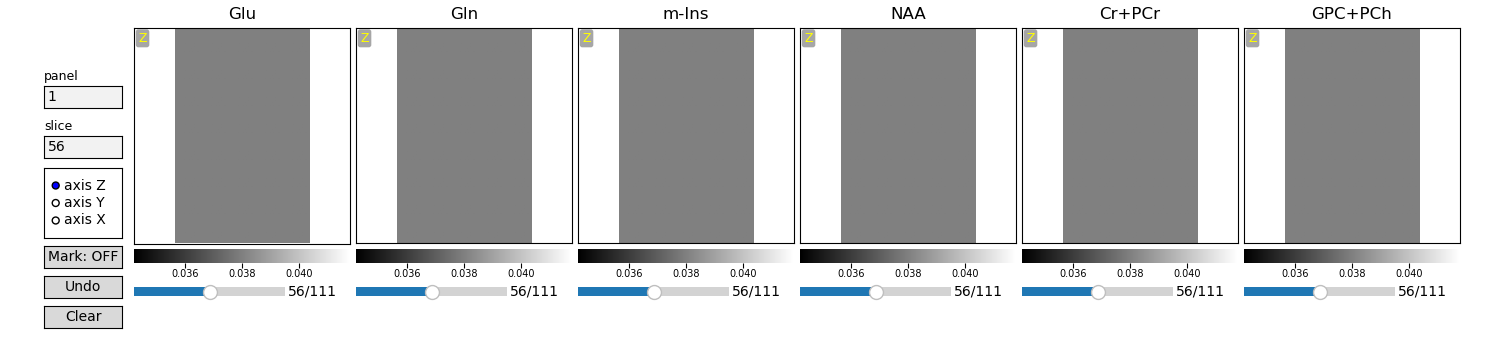

In [29]:
import time
time.sleep(1)
t2_volume.display_jupyter()

# Use desired FID signals and merge some of them

In [30]:
text = """ =====================================================================================================
        Step: Partially FID
        
        ´Description: Take a subset of all desired signals of the FID. Some signals need to be combined individually by
                      adding them and dividing it then by a certain factor.´
        
            [X] Combine Creatine ( Cr ) and Phosphocreatine ( PCr ) -> Cr+PCr (divisor = 2)
           ´[X] Combine Choline_moi( GPC ) and Glycerol_moi( GPC ) and PhosphorylCholine_new1 ( PC ) -> GPC+PCh 
                (divisor = 2)´
        """
g.add_node(name="Partially FID", text=text, cluster="Load and prepare the data",title_colour="green", width=1.1)

using_fid_signals = ["Glutamate (Glu)",
                     "Glutamine_noNH2 (Gln)",
                     "MyoInositol (m-Ins)",
                     "NAcetylAspartate (NAA)",
                     "Creatine (Cr)",
                     "Phosphocreatine (PCr)",
                     "Choline_moi(GPC)",
                     "Glycerol_moi(GPC)",
                     "PhosphorylCholine_new1 (PC)"]

In [31]:
# Take a subset of all signals of the FID. This returns a new FID object.
fid = loaded_fid.get_partly_fid(using_fid_signals)

# Merge signals of the FID in order to match the Maps
fid.merge_signals(names=["Creatine (Cr)", "Phosphocreatine (PCr)"],
                  new_name="Cr+PCr",
                  divisor=2)

fid.merge_signals(names=["Choline_moi(GPC)", "Glycerol_moi(GPC)", "PhosphorylCholine_new1 (PC)"],
                  new_name="GPC+PCh",
                  divisor=2)

fid.name = fid.get_name_abbreviation()

[ 27  ][ success ] ---v  (automatic line breaks) 
                      Merged signals of ['Creatine (Cr)', 'Phosphocreatine (PCr)'] with factor 1/2. New name of signal:
                      Cr+PCr
[ 28  ][ success ] ---v  (automatic line breaks) 
                      Merged signals of ['Choline_moi(GPC)', 'Glycerol_moi(GPC)', 'PhosphorylCholine_new1 (PC)'] with
                      factor 1/2. New name of signal: GPC+PCh


# Create Spectral-Spatial Model (Spectral-spatial combination)

Incorporating the T1 and T2 effects: T1 transform the signal height (Recovery). Thus bigger T1 or shorter TR -> less signal. T2 dampens the signal, this bigger T2 -> slower decay. Bigger T2 -> faste decay (less signal)

T1-transform:
$V_{\text{out}} = V_{\text{in}} \, \sin(\alpha)\, \frac{1 - e^{-TR/T_1}}{1 - \cos(\alpha)\, e^{-TR/T_1}}$

T2-transform:
$V_{\text{out}} = V_{\text{in}} \, e^{-\frac{TE + t}{T_2}}$


#### Ensure that each map has the same order

In [32]:
# (1) Ensure that the metabolite order is the same for all volumes
desired_order = ['Glu', 'Gln', 'm-Ins', 'NAA', 'Cr+PCr', 'GPC+PCh']
concentration_volume.reorder_metabolites(desired_order)
t1_volume.reorder_metabolites(desired_order)
t2_volume.reorder_metabolites(desired_order)

[ 29  ][ warning ] >> No sorting is applied since already desired order is given!                                          
[ 30  ][ warning ] >> No sorting is applied since already desired order is given!                                          
[ 31  ][ warning ] >> No sorting is applied since already desired order is given!                                          


#### Create the model

In [33]:
block_size = (int(35), int(112), int(128), int(80))

spectral_spatial_model = SpectralSpatialModel(path_cache=configurator.data["cache"],
                                              block_size=block_size,  # Note, also possible: 1536x10x10x10
                                              TE=TE,
                                              TR=TR,
                                              alpha=alpha,
                                              data_type="complex64",
                                              compute_on_device="cuda",
                                              return_on_device="cpu") # TODO: When doing here cpu next part then cuda has issue!


# Add all the parameter maps (spatial)
spectral_spatial_model.add_parameter_volume("T1", t1_volume)
spectral_spatial_model.add_parameter_volume("T2", t2_volume)
spectral_spatial_model.add_parameter_volume("concentration", concentration_volume)
spectral_spatial_model.add_mask(metabolic_mask.mask.data)                       # Mask of brain

# Add the FID signals (spectral)
#fid.time = fid.time * u.s # to add seconds # TODO
spectral_spatial_model.add_fid(fid)                                             # Add FID (all separate signals summed up)

spectral_spatial_model.model_summary()

[ 32  ][ success ] >> Added T1 to the Spectral Spatial Model.                                                              
[ 33  ][ success ] >> Added T2 to the Spectral Spatial Model.                                                              
[ 34  ][ success ] >> Added concentration to the Spectral Spatial Model.                                                   
[ 35  ][ success ] ---v  (collected several lines)                      
                      Added the following FID signals to the spectral spatial model:
                      0: Glu
                      1: Gln
                      2: m-Ins
                      3: NAA
                      4: Cr+PCr
                      5: GPC+PCh
                      
[ 36  ][  info   ] ---v  (collected several lines)                      
                      Spectral-Spatial-Model Summary:
                       TE          ... 0.0013 second
                       TR          ... 0.6 second
                       alpha      

In [34]:
# To just check the data types
print("fid signal:", spectral_spatial_model.fid.signal.dtype)
print("fid time:", spectral_spatial_model.fid.time.dtype)
print("mask:", spectral_spatial_model.mask.dtype)
print("T1:", spectral_spatial_model.parameter_volumes["T1"].volume.dtype)
print("T2:", spectral_spatial_model.parameter_volumes["T2"].volume.dtype)
print("concentration:", spectral_spatial_model.parameter_volumes["concentration"].volume.dtype)

fid signal: complex64
fid time: float32
mask: float32
T1: float32
T2: float32
concentration: float32


In [35]:
computational_graph_0 = spectral_spatial_model.assemble_graph()
computational_graph_0

[ 37  ][  info   ] >> Start to assemble whole graph on device cuda                                                         


dask.array<to_device, shape=(100000, 112, 128, 80), dtype=complex64, chunksize=(35, 112, 128, 80), chunktype=numpy.ndarray>

In [36]:
####from tools import DaskTools
####computational_graph_0_X = DaskTools.to_zarr(computational_graph_0, path=configurator.data["checkpoints"], checkpoint_folder_name="checkpoint_1_dask_test")

In [37]:
##### 1) Start Cluster
####cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
#####cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
#####WORKS on DL: 
####cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")
####
#####cluster.start_cpu(number_workers=2, threads_per_worker=10, memory_limit_per_worker="60GB")
##### 2) Compute intermediate result
####Console.start_timer()
####volume_computed = computational_graph_0_X.compute()
####Console.stop_timer()
##### 3) Close client and cluster
####cluster.close()
####
####### 4) Convert again to dask array
######computational_graph_1 = da.from_array(volume_computed, chunks=block_size)

In [38]:
###import dask.array as da
###x = da.from_zarr(os.path.join(configurator.data["checkpoints"], "checkpoint_1_dask_test"))  # lazy dask.array.Array

In [39]:
###import matplotlib.pyplot as plt
###
###plt.figure()
###plt.imshow(np.abs(x[20,:,:,50]))
###plt.show()
###
####from tools import JupyterPlotManager
###
####JupyterPlotManager.volume_grid_viewer(vols=[da.absolute(x[10,:,:,:])], rows=1, cols=1, titles=["test"], cmap="viridis")

In [40]:
###from tools import SpaceEstimator
###SpaceEstimator.for_numpy(volume_computed, unit="GiB")

In [41]:
# TODO Check the model pint quantities:

print(type(spectral_spatial_model.fid.time))
print(type(spectral_spatial_model.fid.signal))
print(type(spectral_spatial_model.mask))
print(type(spectral_spatial_model.alpha))
print(type(spectral_spatial_model.TE))
print(type(spectral_spatial_model.TR))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.memmap'>
<class 'pint.Quantity'>
<class 'pint.Quantity'>
<class 'pint.Quantity'>


In [42]:
metabolic_mask.mask.data.shape

(112, 128, 80)

In [43]:
llen = 31

print()


# Sampling model

### Load the coil sensitivity maps

In [44]:
###g.add_node(name="Load and prepare coil sensitivity maps", 
###           text="Load and prepare coil sensitivity maps. Note: Only HDF5 files are supported at the moment, where img and real is separate. It gets combined to complex number..", 
###           cluster="Load and prepare the data",
###           title_colour="yellow")
###
###
from file import CoilSensitivityMaps
coil_sensitivity_maps_loader = file.CoilSensitivityMaps(configurator=configurator)
coil_sensitivity_maps_loader.load_h5py(keys=["imag", "real"], dtype=np.complex64)

#target_size = (32, metabolic_mask.mask.data.shape[0], metabolic_mask.mask.data.shape[1], metabolic_mask.mask.data.shape[2])
###
###g.add_node(name="Interpolate coil sensitivity", text=f"Interpolate coil sensitivity maps to {target_size}", cluster="Interpolation", width=0.5)
#coil_sensitivity_maps = coil_sensitivity_maps_loader.interpolate(target_size=target_size, order=2, compute_on_device='cuda', gpu_index=target_gpu_smaller_tasks, return_on_device='cpu') # TODO TODO TODO TODO

[ 38  ][ success ] ---v  (collected several lines)                      
                      Coil Sensitivity Maps:
                       => Could find keys ['imag', 'real'] in the HDF5 file
                       => Loaded and converted maps to complex64
                       => Data shape: (32, 80, 86, 86)
                       => Space required: 144.45 mebibyte
                      


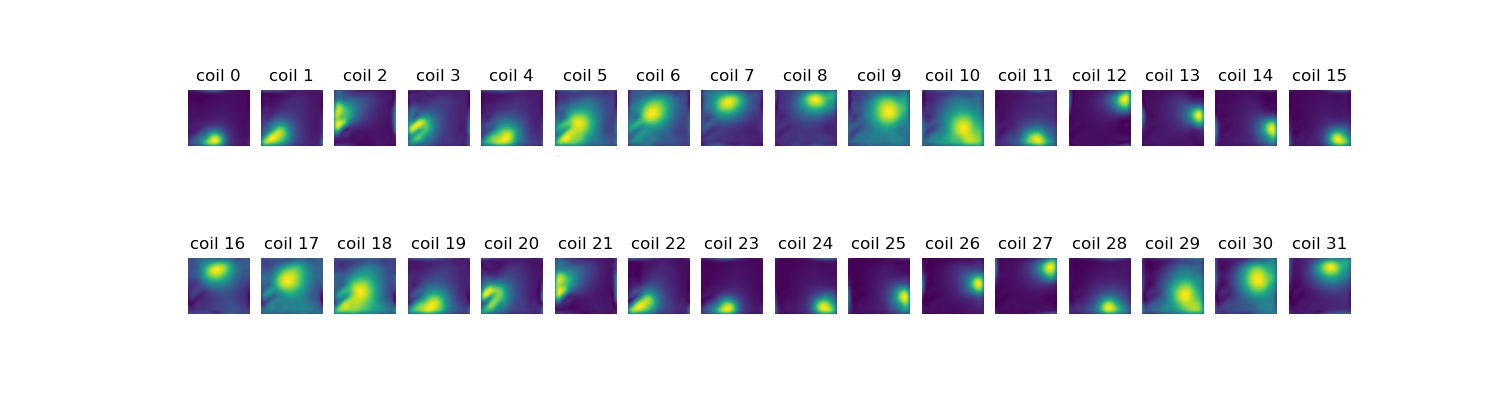

In [45]:
#coil_sensitivity_maps_loader.plot_jupyter(cmap="viridis")
coil_sensitivity_maps_loader.plot(cmap="viridis")

In [46]:
coil_sensitivity_maps = coil_sensitivity_maps_loader.to_working_volume()

In [45]:
coil_sensitivity_maps_loader.maps.shape

(32, 80, 86, 86)

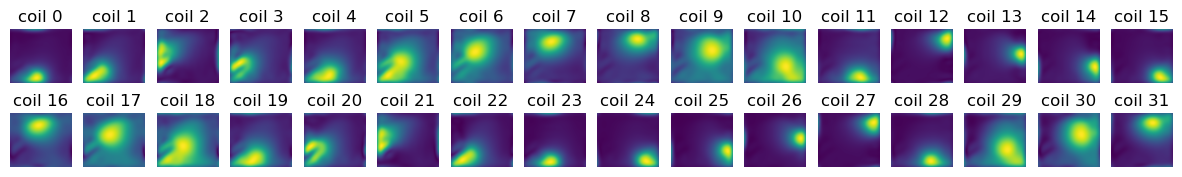

In [40]:
fig, axs = plt.subplots(
    nrows=2,
    ncols=coil_sensitivity_maps.shape[0] // 2,
    figsize=(15, 2)
)

for i, ax in enumerate(axs.flat):
    ax.imshow(np.abs(coil_sensitivity_maps[i, :, :, 40]))
    #ax.imshow(np.abs(coil_sensitivity_maps[i, :, :, 40].get()))
    ax.axis("off")
    ax.set_title(f"coil {i}")

### Create the sampling model & Apply the coil sensitivity maps

In [41]:
text = """ =====================================================================================================
        Step: Create Sampling Model
        
        Description: `To create plain sampling model and then apply the coil sensitivity maps.
        This includes 32 coild sensitivity maps and thus extends the shape from [t,x1,x2,x3] 
        to [coils, t, x1,x2,x3].`
        
            [ ] fix that path cache has no effect!
        """
g.add_node(name="Create Sampling Model",
           text=text, 
           cluster="Create models",
           title_colour="yellow")

# (A) Create the sampling model
block_size_computational_graph_spectral_spatial_model = (int(20), int(112), int(128), int(80))
block_size_coil_sensitivity_maps = (int(20), int(112), int(128), int(80))

sampling_model = SamplingModel(computational_graph_spectral_spatial_model=computational_graph_1,
                               block_size_computational_graph_spectral_spatial_model=block_size_computational_graph_spectral_spatial_model,
                               coil_sensitivity_maps=coil_sensitivity_maps,
                               block_size_coil_sensitivity_maps=block_size_coil_sensitivity_maps,
                               path_cache="This/was/a/real/path/but/still/has/no/effect", # TODO: has no effect! <- seems to have an effect!
                               persist_computational_graph_spectral_spatial_model=False
                               )

# (B) Apply the coil sensitivity maps
# Volume (coil, time, X, Y, Z)
computational_graph_2 = sampling_model.apply_coil_sensitivity_maps(compute_on_device='cuda', return_on_device='cuda')
#computational_graph_3 = sampling_model.coil_combination(volume_with_coil_sensitivity=computational_graph_2, compute_on_device='cuda', return_on_device='cpu')
computational_graph_2

[ 37  ][  info   ] >> Sampling Model: Converting coil_sensitivity_maps <class 'numpy.ndarray'> --> dask Array              
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<


dask.array<mul, shape=(32, 1536, 112, 128, 80), dtype=complex64, chunksize=(20, 20, 112, 128, 80), chunktype=cupy.ndarray>

# Cartesian k-Space & Cropping

In [42]:
crop_center_shape = (64, 64, 40)

g.add_node(name="Cartesian Fourier Transformation",
           text=f"To bring the 4D volume of each coil to k-space and to spatially crop the center for each to {crop_center_shape}.", 
           cluster="k-space")

computational_graph_3 = sampling_model.cartesian_FFT(volumes_with_coil_sensitivity_maps=computational_graph_2,
                                                     crop_center_shape=crop_center_shape,
                                                     compute_on_device='cuda',  # cuda works with 100_000
                                                     return_on_device='cuda')   # cpu works with 100_000

[ 38  ][ success ] ---v  (collected several lines)                      
                      Performed FFT for:
                       > Coil 1
                       > Coil 2
                       > Coil 3
                       > Coil 4
                       > Coil 5
                       > Coil 6
                       > Coil 7
                       > Coil 8
                       > Coil 9
                       > Coil 10
                       > Coil 11
                       > Coil 12
                       > Coil 13
                       > Coil 14
                       > Coil 15
                       > Coil 16
                       > Coil 17
                       > Coil 18
                       > Coil 19
                       > Coil 20
                       > Coil 21
                       > Coil 22
                       > Coil 23
                       > Coil 24
                       > Coil 25
                       > Coil 26
                       > Coil 27
    

#### <span style="color:red">!!! The following step is just a test regarding selecting the only the desired GPU (not utilise GPU = as currently)</span>

In [43]:
# 1) Start Cluster
cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")

#------------------------------------------------
Console.start_timer()

test_gpu = computational_graph_3[0].compute()


Console.stop_timer()
#------------------------------------------------

# 3) Close client and cluster
cluster.close()

[ 39  ][ warning ] >> nvml diagnostics is disabled!                                                                        
[ 40  ][  info   ] >> Splitting large chunks is activated                                                                  


Unable to start CUDA Context
Traceback (most recent call last):
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/dask_cuda/initialize.py", line 31, in _create_cuda_context
    distributed.comm.ucx.init_once()
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/distributed/comm/ucx.py", line 133, in init_once
    cuda_visible_device = get_device_index_and_uuid(
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/distributed/diagnostics/nvml.py", line 256, in get_device_index_and_uuid
    device_handle = pynvml.nvmlDeviceGetHandleByIndex(device_index)
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/pynvml.py", line 2914, in nvmlDeviceGetHandleByIndex
    fn = _nvmlGetFunctionPointer("nvmlDeviceGetHandleByIndex_v2")
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/pynvml.py", line 1074, in _nvmlGetFunctionPointer
    raise NVMLError(NVML_ERROR_UNINITIALIZED)
pynvml.NVMLError_Uninitialized: Unini

[ 41  ][ success ] >> Started cuda Cluster 
 Link to dashboard: /proxy/55000/status                                        
         START TIMER          
       TOOK 102.458 sec       
[ 42  ][ success ] >> Successfully closed client                                                                           
[ 43  ][ success ] >> Successfully closed cluster                                                                          


# Back to i-Space (IFFT)

In [44]:
g.add_node(name="Cartesian Fourier Transformation",
           text=f"To bring the 4D volume of each coil to k-space and to spatially crop the center for each to {crop_center_shape}.", 
           cluster="k-space")

computational_graph_4 = sampling_model.cartesian_IFFT(volumes_cartesian_k_space=computational_graph_3,
                                                      compute_on_device='cuda',   # cuda work with 100_000
                                                      return_on_device='cuda')    # cpu work with 100_000

(!) Node already exists: Cartesian Fourier Transformation
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy array! <<<<<<<
>>>>>>> Transform numpy array to cupy arr

In [45]:
interpolate_sensitivity_maps = (32,) + crop_center_shape

g.add_node(name="Interpolate coil sensitivity (ifft)", text=f"Interpolate coil sensitivity maps to {interpolate_sensitivity_maps}. For Coil combination after IFFT.", cluster="Interpolation", width=0.5)

coil_sensitivity_maps_resized = coil_sensitivity_maps_loader.interpolate(target_size=interpolate_sensitivity_maps, order=2, compute_on_device='cuda', gpu_index=target_gpu_smaller_tasks, return_on_device='cuda') # TODO TODO TODO TODO

[ 44  ][  info   ] >> Start interpolating coil sensitivity maps                                                            
[ 45  ][ success ] ---v  (collected several lines)                      
                      Interpolated the coil sensitivity maps:
                       => From size: (32, 112, 128, 80) --> (32, 64, 64, 40)
                       => with interpolation order: 2
                       => on device cuda:2 --> and returned on cuda
                      


In [46]:
computational_graph_4

[dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(20, 64, 64, 40), chunktype=cupy.ndarray>,
 dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(20, 64, 64, 40), chunktype=cupy.ndarray>,
 dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(20, 64, 64, 40), chunktype=cupy.ndarray>,
 dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(20, 64, 64, 40), chunktype=cupy.ndarray>,
 dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(20, 64, 64, 40), chunktype=cupy.ndarray>,
 dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(20, 64, 64, 40), chunktype=cupy.ndarray>,
 dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(20, 64, 64, 40), chunktype=cupy.ndarray>,
 dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, chunksize=(20, 64, 64, 40), chunktype=cupy.ndarray>,
 dask.array<asarray, shape=(1536, 64, 64, 40), dtype=complex64, 

In [47]:
import cupy as cp
import dask
import dask.array as da


graphs_da = da.stack([da.asarray(g) for g in computational_graph_4], axis=0)   # (32,1536,64,64,40)
coils_da  = da.stack([da.asarray(c) for c in coil_sensitivity_maps_resized], axis=0)  # (32,64,64,40)

# IMPORTANT: make coils broadcast over the 1536 dimension
coils_da_b = coils_da[:, None, ...]  # (32,1,64,64,40)

num_da = da.sum(graphs_da * da.conj(coils_da_b), axis=0)   # -> (1536,64,64,40)
den_da = da.sum(da.absolute(coils_da) ** 2, axis=0)        # -> (64,64,40)

/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/cupy/_manipulation/join.py:60: PerformanceWarning: The device where the array resides (2) is different from the current device (0). Peer access has been activated automatically.
  return _core.concatenate_method(tup, axis, out, dtype, casting)


In [48]:
text = f""" =====================================================================================================
        Step: Compute the forward process
        
        Description: `This computes the sampling model and also includes a forward process to check the data.`
            [x] 1. Bring to k-space (thus FFT to dimensions 1,2,3 excluding 0)
            [x] 2. Crop the center to {crop_center_shape}
            [x] 3. IFFT back to image space
            [x] 4. Interpolate coil sensitivity maps to {crop_center_shape}
            [x] 5. Could combination with resized coil sensitivity maps
        
        """

g.add_node(name="Compute the forward process",
           text=text,
           cluster="GPU cluster",
           title_colour="green")


# Start cluster again!
# 1) Start Cluster
cluster = tools.MyLocalCluster(nvml_diagnostics=False, split_large_chunks=True)
#cluster.start_cuda_test(device_numbers=target_gpus_big_tasks, memory_limit_per_worker="16GB")
#WORKS on DL: 
cluster.start_cuda(device_numbers=target_gpus_big_tasks, device_memory_limit=device_memory_limit, use_rmm_cupy_allocator=True, protocol="tcp")

#------------------------------------------------
Console.start_timer()

num, den = dask.compute(num_da, den_da) 

num = cp.asnumpy(num) if isinstance(num, cp.ndarray) else num
den = cp.asnumpy(den) if isinstance(den, cp.ndarray) else den

Console.stop_timer()
#------------------------------------------------

# 3) Close client and cluster
cluster.close()
# 4) Convert again to dask array
computational_graph_1 = da.from_array(volume_computed, chunks=block_size)

[ 46  ][ warning ] >> nvml diagnostics is disabled!                                                                        
[ 47  ][  info   ] >> Splitting large chunks is activated                                                                  


Unable to start CUDA Context
Traceback (most recent call last):
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/dask_cuda/initialize.py", line 31, in _create_cuda_context
    distributed.comm.ucx.init_once()
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/distributed/comm/ucx.py", line 133, in init_once
    cuda_visible_device = get_device_index_and_uuid(
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/distributed/diagnostics/nvml.py", line 256, in get_device_index_and_uuid
    device_handle = pynvml.nvmlDeviceGetHandleByIndex(device_index)
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/pynvml.py", line 2914, in nvmlDeviceGetHandleByIndex
    fn = _nvmlGetFunctionPointer("nvmlDeviceGetHandleByIndex_v2")
  File "/opt/conda/envs/MRSI_simulation/lib/python3.10/site-packages/pynvml.py", line 1074, in _nvmlGetFunctionPointer
    raise NVMLError(NVML_ERROR_UNINITIALIZED)
pynvml.NVMLError_Uninitialized: Unini

[ 48  ][ success ] >> Started cuda Cluster 
 Link to dashboard: /proxy/55000/status                                        
         START TIMER          
       TOOK 121.511 sec       
[ 49  ][ success ] >> Successfully closed client                                                                           
[ 50  ][ success ] >> Successfully closed cluster                                                                          


#### <span style="color:red">Signal height is too much?</span>

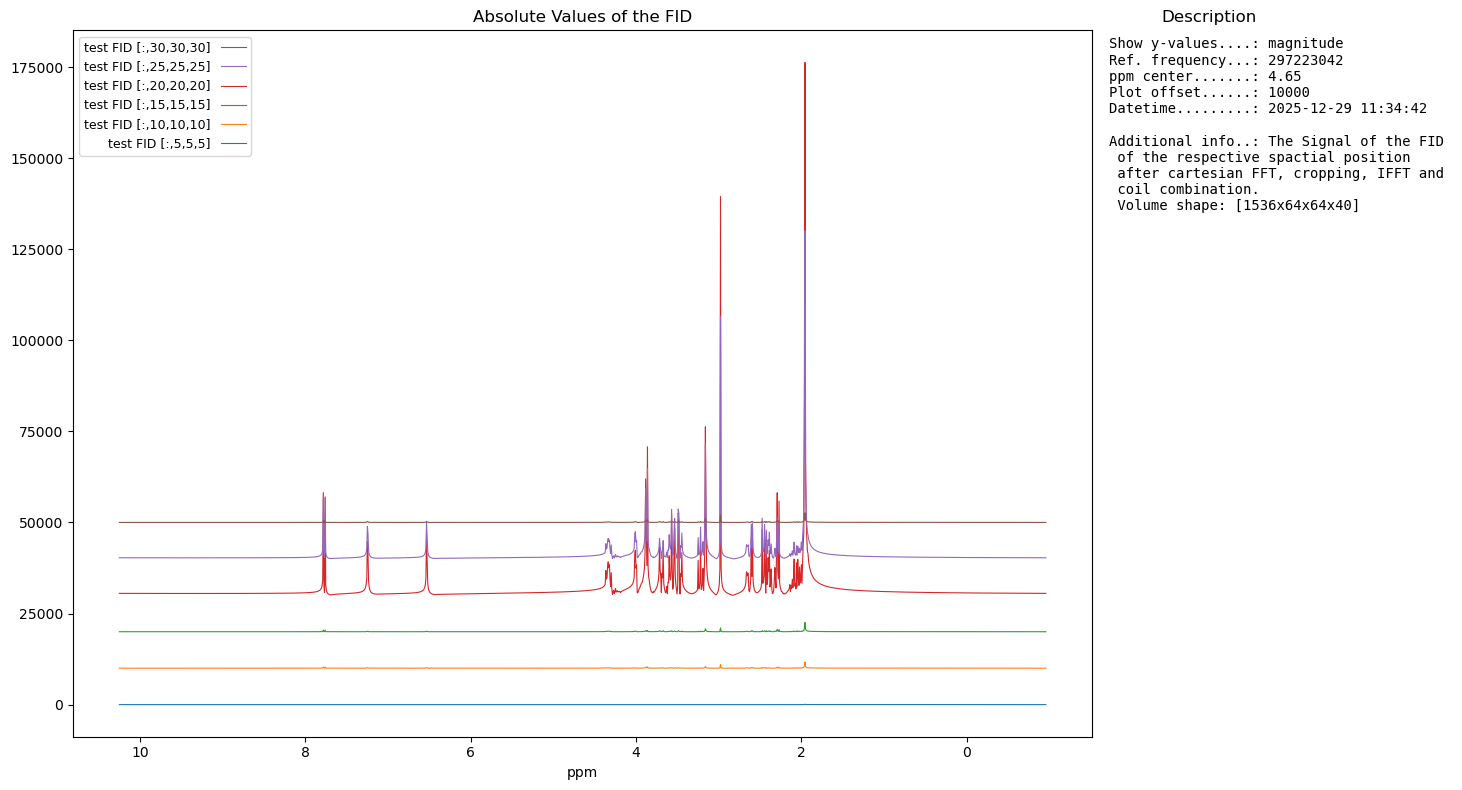

In [49]:
result = num/den
result.shape

test_fid = FID()

for i in range(5,35,5):
    test_fid += FID(
        signal=result[:,i,i,i], 
        time=loaded_fid.time, 
        name=[f"test FID [:,{i},{i},{i}]"])

#test_fid = FID(signal=result[:,20,20,20], time=loaded_fid.time, name=["test FID 1"])
test_fid.plot(additional_description="The Signal of the FID \n of the respective spactial position \n after cartesian FFT, cropping, IFFT and \n coil combination. \n Volume shape: [1536x64x64x40]", plot_offset=10000)

In [50]:
#result

In [51]:
#plt.plot(result[:, 20,20,20].compute())

#result.shape

In [52]:
g.create()
g.save("cartesian__easy_graph_test_2")

In [53]:
import dask, distributed, bokeh
import dask_labextension

print("dask:", dask.__version__)
print("distributed:", distributed.__version__)
print("bokeh:", bokeh.__version__)
print("dask_labextension:", dask_labextension.__version__)


dask: 2023.9.2
distributed: 2023.9.2
bokeh: 3.2.2
dask_labextension: 7.0.0


In [54]:
!jupyter lab --version

4.5.0
